# Imdb Movies' EDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy import stats

from helper import *

pd.set_option('display.max_columns', 100)

## The question

What factors make a movie financially successful? Is it a question of genre and/or actors and directors taking part in the movie or do the movie rating sites play a role in making a movie successful (or, as it has been said [here](http://www.hollywoodreporter.com/news/studios-fight-back-withering-rotten-tomatoes-scores-1025575), *unsuccessful*)?

## Importing the Data

We start by reading the pickle file containing the imdb and budget data and looking at the top movies by worldwide ROI:

In [2]:
imdb = pd.read_pickle('pickle/imdb_full.p')

In [3]:
imdb[['movie_title', 'release_year', 'worldwide_ROI', 'adj_production_budget', 'adj_worldwide_gross', 'budget_type']].sort_values(by='worldwide_ROI', ascending=False).head(10)

,movie_title,release_year,worldwide_ROI,adj_production_budget,adj_worldwide_gross,budget_type
430,Paranormal Activity,2009.0,430.517853,5.034244e+05,2.172366e+08,low
430,The Gallows,2015.0,416.538810,1.012615e+05,4.228061e+07,micro
430,The Blair Witch Project,1999.0,412.833333,8.643709e+05,3.577055e+08,low
430,Super Size Me,2004.0,341.058585,8.258579e+04,2.824918e+07,micro
430,Bambi,1942.0,311.354312,1.263350e+07,3.946127e+09,normal
430,El Mariachi,1993.0,290.704000,1.162664e+04,3.391536e+06,micro
430,Rocky,1976.0,224.000000,4.218049e+06,9.490611e+08,normal
430,Halloween,1978.0,214.384615,1.196354e+06,2.576762e+08,low
430,The Brothers McMullen,1995.0,207.530120,7.874245e+04,1.642017e+07,micro
430,American Graffiti,1973.0,179.180180,4.200122e+06,7.567788e+08,normal


As you can see, in the top positions we have a lot of low and micro budget movies (having low budgets it seems quite natural that successful ones would have high ROI); since we want to investigate what makes a movie financially successful, in our analysis we will assume that we are interested only in normal budget movies. Moreover, we will look only at movies released after 2000 because we would like to assert the influence of online ratings.

Using this filters there remain 2731 movies in our dataset:

In [4]:
normal_post2000 = imdb[(imdb.release_year >= 2000) & (imdb.budget_type == 'normal')].copy()
len(normal_post2000)

2731

Now we add a column that categorizes the financial success of a movie in five bins, using the percentiles as a guidance:

In [5]:
normal_post2000.worldwide_ROI.quantile([0.2, 0.4, 0.6, 0.8])

0.2   -0.347397
0.4    0.453957
0.6    1.459903
0.8    3.161891
Name: worldwide_ROI, dtype: float64

In [6]:
print(len(normal_post2000[normal_post2000.worldwide_ROI <= -0.5]))
print(len(normal_post2000[normal_post2000.worldwide_ROI <= 0]))
print(len(normal_post2000[normal_post2000.worldwide_ROI <= 1.5]))
print(len(normal_post2000[normal_post2000.worldwide_ROI <= 3]))

434
808
1657
2151


In [7]:
def movie_success(ROI):
    if ROI <= -0.5:
        return 'very bad'
    if ROI <= 0:
        return 'bad'
    if ROI <= 1.5:
        return 'good'
    if ROI <= 3:
        return 'very good'
    if ROI > 3:
        return 'excellent'
    else:
        return 'missing'

In [8]:
normal_post2000['movie_success'] = normal_post2000.worldwide_ROI.apply(movie_success)


## Analysis by Actor

From now on we investigate the eventual correlation between actors, directors and genres with the success of a movie.

We start by creating a list of all the actors in the dataset and calculating the ROI for every one of them based on all the movies they were in.

In [9]:
actors = actors_list(normal_post2000)
len(actors)

3530

(I think I should account for actor's importance in the movie, such as assigning 1/2, 1/3, 1/6 -> 1, 2/3, 1/3 but I won't do it for the moment being.)

In [10]:
imdb_by_actor = movies_by_actor(normal_post2000, actors)

Let's see who the top 20 actors with at least 10 movies by worldwide ROI are:

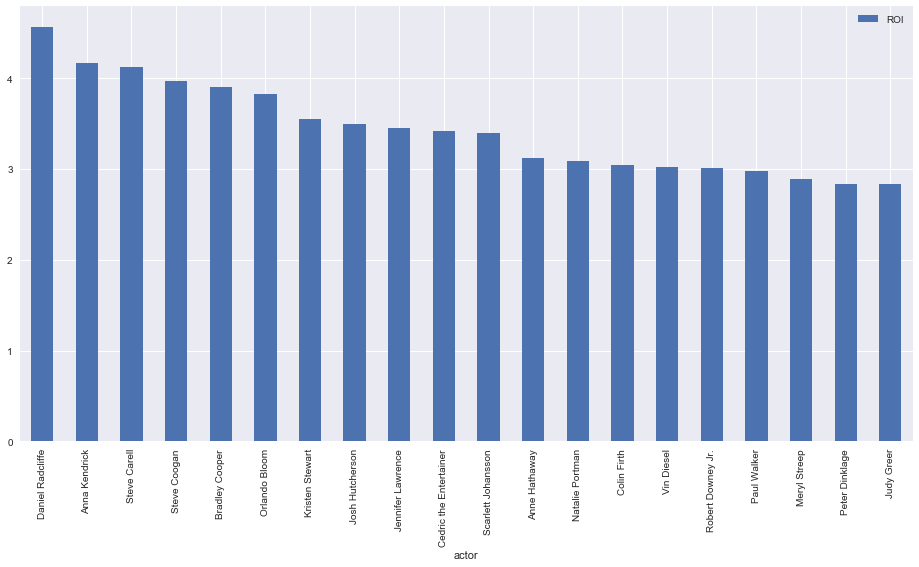

In [11]:
imdb_actors_ROI = actors_ROI(imdb_by_actor)
ax = imdb_actors_ROI[(imdb_actors_ROI.number_movies > 9)].sort_values(by='ROI', ascending=False).head(20).plot.bar(y=['ROI'], figsize=(16, 8))
fig = ax.get_figure()
fig.savefig('figures/top_actors.png');

To see if the presence of an actor is related to the success of a movie, we will add the actor's ROI to every movie they were in and use the same logic used for the movies to categorize them in bins. We will do so for actor number 1, 2 and 3:

In [12]:
normal_post2000 = normal_post2000.merge(
    imdb_actors_ROI[['ROI', 'number_movies']], left_on='actor_1_name', right_index=True, how='left').rename(
    columns={
        'ROI_x':'movie_ROI',
        'ROI_y':'actor_1_ROI',
        'number_movies':'actor_1_number_movies'
    })

normal_post2000['actor_1_success'] = normal_post2000.actor_1_ROI.apply(movie_success)

In [13]:
normal_post2000 = normal_post2000.merge(
    imdb_actors_ROI[['ROI', 'number_movies']], left_on='actor_2_name', right_index=True, how='left').rename(
    columns={
        'ROI':'actor_2_ROI',
        'number_movies':'actor_2_number_movies'
    })

normal_post2000['actor_2_success'] = normal_post2000.actor_2_ROI.apply(movie_success)

In [14]:
normal_post2000 = normal_post2000.merge(
    imdb_actors_ROI[['ROI', 'number_movies']], left_on='actor_3_name', right_index=True, how='left').rename(
    columns={
        'ROI':'actor_3_ROI',
        'number_movies':'actor_3_number_movies'
    })

normal_post2000['actor_3_success'] = normal_post2000.actor_3_ROI.apply(movie_success)

Now, we use a chi square contingency test to see movie success and actor success are related:

In [15]:
cross_actor_1 = pd.crosstab(index=normal_post2000.movie_success, columns=normal_post2000.actor_1_success)
print('Contingency table for actor 1:\n\n{}\n'.format(cross_actor_1))
test_actor_1 = stats.chi2_contingency(cross_actor_1)
print('Expected values for actor 1:\n\n{}\n'.format(test_actor_1[-1]))
print('p-value for actor 1: {}\n'.format(test_actor_1[1]))

Contingency table for actor 1:

actor_1_success  bad  excellent  good  very bad  very good
movie_success                                             
bad               83         36   131         8        116
excellent          3        249    70         0        258
good              15         62   439         2        331
very bad          31         33   142       112        116
very good          3         45   141         0        305

Expected values for actor 1:

[[  18.48773343   58.20212376  126.4013182    16.70743317  154.20139143]
 [  28.67081655   90.25997803  196.02343464   25.90992311  239.13584767]
 [  41.96814354  132.12193336  286.93775174   37.92676675  350.04540461]
 [  21.45367997   67.53936287  146.67960454   19.38777005  178.93958257]
 [  24.41962651   76.87660198  166.95789088   22.06810692  203.67777371]]

p-value for actor 1: 1.3484523348907006e-293



In [16]:
cross_actor_2 = pd.crosstab(index=normal_post2000[normal_post2000.actor_2_success != 'missing'].movie_success,
                            columns=normal_post2000[normal_post2000.actor_2_success != 'missing'].actor_2_success)
print('Contingency table for actor 2:\n\n{}\n'.format(cross_actor_2))
test_actor_2 = stats.chi2_contingency(cross_actor_2)
print('Expected values for actor 2:\n\n{}\n'.format(test_actor_2[-1]))
print('p-value for actor 2: {}\n'.format(test_actor_2[1]))

Contingency table for actor 2:

actor_2_success  bad  excellent  good  very bad  very good
movie_success                                             
bad              153         23   131        10         57
excellent          2        310    81         0        187
good              35         38   575         8        192
very bad          38         21   151       175         49
very good          5         42   151         0        296

Expected values for actor 2:

[[  31.92014652   59.45641026  149.18901099   26.44029304  106.99413919]
 [  49.5018315    92.20512821  231.36263736   41.003663    165.92673993]
 [  72.37509158  134.81025641  338.26813187   59.95018315  242.596337  ]
 [  37.04102564   68.99487179  173.12307692   30.68205128  124.15897436]
 [  42.16190476   78.53333333  197.05714286   34.92380952  141.32380952]]

p-value for actor 2: 0.0



In [17]:
cross_actor_3 = pd.crosstab(index=normal_post2000[normal_post2000.actor_3_success != 'missing'].movie_success,
                            columns=normal_post2000[normal_post2000.actor_3_success != 'missing'].actor_3_success)
print('Contingency table for actor 3:\n\n{}\n'.format(cross_actor_3))
test_actor_3 = stats.chi2_contingency(cross_actor_3)
print('Expected values for actor 3:\n\n{}\n'.format(test_actor_3[-1]))
print('p-value for actor 3: {}\n'.format(test_actor_3[1]))

Contingency table for actor 3:

actor_3_success  bad  excellent  good  very bad  very good
movie_success                                             
bad              189         15   110        13         47
excellent          4        378    55         0        143
good              27         37   639         1        143
very bad          42         13    98       250         30
very good          3         44   153         0        293

Expected values for actor 3:

[[  36.34396773   66.79061239  144.69013568   36.20682068   89.96846351]
 [  56.3623029   103.57902457  224.38577191   56.14961496  139.52328566]
 [  82.30839751  151.26109278  327.68060139   81.99779978  203.75210854]
 [  42.0773744    77.32709938  167.51558489   41.91859186  104.16134947]
 [  47.90795746   88.04217088  190.72790612   47.72717272  118.59479281]]

p-value for actor 3: 0.0



Since all the expected values are over 5 and the p-values are much less than 0.01 we can reject the null hypothesis that movie and actor success are independent.

## Analysis by Director

Now we repeat all the steps above for the directors:

In [18]:
directors = directors_list(normal_post2000)
len(directors)

1388

In [19]:
imdb_by_director = movies_by_director(normal_post2000, directors)

Let's see who the top 20 directors with at least 5 movies by worldwide ROI are:

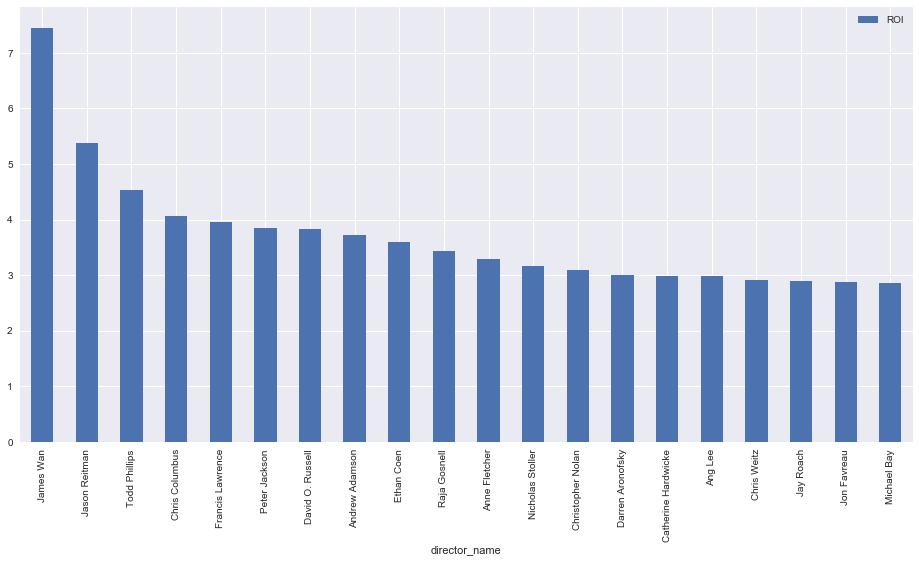

In [20]:
imdb_directors_ROI = directors_ROI(imdb_by_director)
ax = imdb_directors_ROI[(imdb_directors_ROI.number_movies > 4)].sort_values(by='ROI', ascending=False).head(20).plot.bar(y=['ROI'], figsize=(16, 8));
fig = ax.get_figure()
fig.savefig('figures/top_directors.png');

Here we create the director success column and test for independence with the movie success:

In [21]:
normal_post2000 = normal_post2000.merge(
    imdb_directors_ROI[['ROI', 'number_movies']], left_on='director_name', right_index=True, how='left').rename(
    columns={
        'ROI':'director_ROI',
        'number_movies':'director_number_movies'
    })

normal_post2000['director_success'] = normal_post2000.director_ROI.apply(movie_success)

In [22]:
cross_director = pd.crosstab(index=normal_post2000.movie_success,
                            columns=normal_post2000.director_success)
print('Contingency table for director:\n\n{}\n'.format(cross_director))
test_director = stats.chi2_contingency(cross_director)
print('Expected values for director:\n\n{}\n'.format(test_director[-1]))
print('p-value for director: {}\n'.format(test_director[1]))

Contingency table for director:

director_success  bad  excellent  good  very bad  very good
movie_success                                              
bad               177         11   125        12         49
excellent           0        294    66         0        220
good               33         33   571         6        206
very bad           40         10    80       281         23
very good           1         48   147         0        298

Expected values for director:

[[  34.37348956   54.23068473  135.43976565   40.9469059   109.00915416]
 [  53.30648114   84.10106188  210.04027829   63.50054925  169.05162944]
 [  78.02965947  123.10655438  307.4555108    92.95166606  247.4566093 ]
 [  39.88795313   62.93079458  157.1680703    47.51592823  126.49725375]
 [  45.4024167    71.63090443  178.89637495   54.08495057  143.98535335]]

p-value for director: 0.0



The p-value is 0, so we can reject the null hypothesis of independence for the director too.

## Analysis by Genre

Now we'll do the same analysis for the genres: since we don't have many of them we can use the genres directly without assigning categories to them.

In [23]:
imdb_by_genre = movies_by_genre_worldwide(normal_post2000)
imdb_by_genre['movie_success'] = imdb_by_genre.worldwide_ROI.apply(movie_success)

In [24]:
cross_genre = pd.crosstab(index=imdb_by_genre.movie_success,
                            columns=imdb_by_genre.genre)
print('Contingency table for genre:\n\n{}\n'.format(cross_genre))
test_genre = stats.chi2_contingency(cross_genre)
print('Expected values for genre:\n\n{}\n'.format(test_genre[-1]))
print('p-value for genre: {}\n'.format(test_genre[1]))

Contingency table for genre:

genre          Action  Adventure  Animation  Biography  Comedy  Crime  \
movie_success                                                           
bad                85         65         14         28     162     75   
excellent         110        128         61         40     244     68   
good              245        181         55         53     342    185   
very bad           80         45         13         36     160     90   
very good         143        130         30         27     205     81   

genre          Documentary  Drama  Family  Fantasy  History  Horror  Music  \
movie_success                                                                
bad                      5    203      36       39       21      29     34   
excellent               18    262      99       91       19      76     45   
good                     6    409     125      124       39      61     40   
very bad                 7    301      28       33       19      28 

Unfortunately, some of the expected counts are under 5 so we can't use the chi square test. This happens because some of the genres have very few movies, we can though use the top genres by number of movies to perform the test:

In [25]:
imdb_genres_ROI = genres_ROI_worldwide(imdb_by_genre)

In [26]:
imdb_genres_ROI.sort_values(by='number_movies', ascending=False).head(15)

,ROI,number_movies,total_budget,total_gross
genre,,,,
Drama,1.450549,1384.0,4.126071e+10,1.011114e+11
Comedy,1.847587,1113.0,4.159500e+10,1.184454e+11
Thriller,1.530693,766.0,3.367724e+10,8.522675e+10
Action,1.741503,663.0,4.964225e+10,1.360944e+11
Romance,1.716543,637.0,2.042148e+10,5.547583e+10
Adventure,2.110928,549.0,5.005327e+10,1.557121e+11
Crime,1.231194,499.0,1.720078e+10,3.837828e+10
Family,2.192180,363.0,2.513620e+10,8.023927e+10
Fantasy,2.096644,353.0,2.830550e+10,8.765205e+10


In [27]:
top15genres = ['Drama', 'Comedy', 'Thriller', 'Action', 'Romance', 'Adventure', 'Crime', 'Family', 'Fantasy', 'Sci-Fi', 'Mystery', 'Horror', 'Biography', 'Animation', 'Music']

In [28]:
cross_genre = pd.crosstab(index=imdb_by_genre.loc[imdb_by_genre.genre.isin(top15genres), 'movie_success'],
                            columns=imdb_by_genre.loc[imdb_by_genre.genre.isin(top15genres), 'genre'])
print('Contingency table for genre:\n\n{}\n'.format(cross_genre))
test_genre = stats.chi2_contingency(cross_genre)
print('Expected values for genre:\n\n{}\n'.format(test_genre[-1]))
print('p-value for genre: {}\n'.format(test_genre[1]))

Contingency table for genre:

genre          Action  Adventure  Animation  Biography  Comedy  Crime  Drama  \
movie_success                                                                  
bad                85         65         14         28     162     75    203   
excellent         110        128         61         40     244     68    262   
good              245        181         55         53     342    185    409   
very bad           80         45         13         36     160     90    301   
very good         143        130         30         27     205     81    209   

genre          Family  Fantasy  Horror  Music  Mystery  Romance  Sci-Fi  \
movie_success                                                             
bad                36       39      29     34       37      103      35   
excellent          99       91      76     45       65      127      63   
good              125      124      61     40       92      186     110   
very bad           28       33    

The p-value is again very low and we reject the null hypothesis of independence between movie success and genre.

## Testing the Ratings 

Finally, we will test whether imdb ratings are related to movie success. We apply the same method as above, binning the scores using the quantiles as guidance:

In [29]:
normal_post2000.imdb_score.quantile([0.2, 0.4, 0.6, 0.8])

0.2    5.6
0.4    6.3
0.6    6.7
0.8    7.3
Name: imdb_score, dtype: float64

In [30]:
print(len(normal_post2000[normal_post2000.imdb_score <= 5]))
print(len(normal_post2000[normal_post2000.imdb_score <= 6]))
print(len(normal_post2000[normal_post2000.imdb_score <= 7]))
print(len(normal_post2000[normal_post2000.imdb_score <= 8]))
print(len(normal_post2000))

261
888
1964
2646
2731


In [31]:
def score_category(score):
    if score <= 5:
        return 'very low'
    if score <= 6:
        return 'low'
    if score <= 7:
        return 'good'
    if score <= 8:
        return 'very good'
    if score <= 10:
        return 'excellent'
    else:
        return 'missing'

In [32]:
normal_post2000['score_category'] = normal_post2000.imdb_score.apply(score_category)

and we repeat the chi square test using the categories just defined:

In [33]:
cross_score = pd.crosstab(index=normal_post2000.movie_success,
                            columns=normal_post2000.score_category)
print('Contingency table for score:\n\n{}\n'.format(cross_score))
test_score = stats.chi2_contingency(cross_score)
print('Expected values for score:\n\n{}\n'.format(test_score[-1]))
print('p-value for score: {}\n'.format(test_score[1]))

Contingency table for score:

score_category  excellent  good  low  very good  very low
movie_success                                            
bad                     5   137  117         68        47
excellent              46   181   81        233        39
good                   11   374  204        184        76
very bad                3   197  110         63        61
very good              20   187  115        134        38

Expected values for score:

[[  11.64042475  147.35408275   85.86525082   93.39729037   35.7429513 ]
 [  18.05199561  228.51702673  133.16001465  144.84071769   55.43024533]
 [  26.42438667  334.50164775  194.91871109  212.01684365   81.13841084]
 [  13.50787257  170.99377517   99.64042475  108.38081289   41.47711461]
 [  15.3753204   194.63346759  113.41559868  123.36433541   47.21127792]]

p-value for score: 2.361167719529988e-38



The p-value is very low, so we can say that the score is related to the movie success.

This is in contrast with the preliminary findings, but the method we used here is very different from the one used previously: here we have binned movie scores and ROI and performed a chi-square test, in the preliminary EDA instead we tried to find a correlation between the raw quantities. Both analysis may have their value, although we could argue that a good or bad evaluation is how we normalyy perceive a raw score.

To wrap it all, we can still perform a one-way ANOVA to test whether the mean of the (non-binned) worldwide ROI differs significantly throughout the score categories:

In [34]:
score_anova = stats.f_oneway(normal_post2000.loc[normal_post2000.score_category=='very low', 'worldwide_ROI'],
                                      normal_post2000.loc[normal_post2000.score_category=='low', 'worldwide_ROI'],
                                      normal_post2000.loc[normal_post2000.score_category=='good', 'worldwide_ROI'],
                                      normal_post2000.loc[normal_post2000.score_category=='very good', 'worldwide_ROI'],
                                      normal_post2000.loc[normal_post2000.score_category=='excellent', 'worldwide_ROI'])

print('ANOVA p-value: {}',format(score_anova[1]))

ANOVA p-value: {} 4.6353484066751246e-21


finding that it does, and plot a heatmap of the contingency table used for the chi-square test between ratings and ROI:

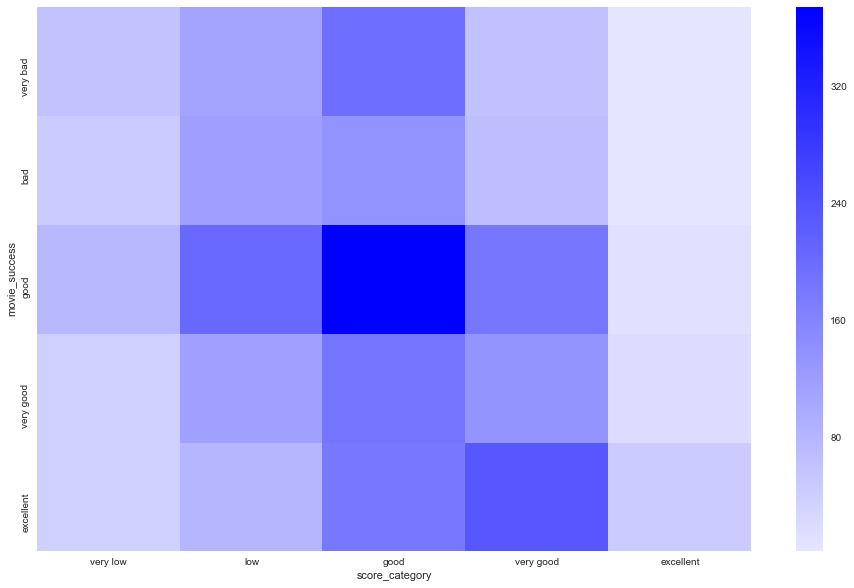

In [35]:
fig, ax = plt.subplots(figsize=(16, 10)) 
ax = sns.heatmap(cross_score.loc[['very bad', 'bad', 'good', 'very good', 'excellent'],
                                 ['very low', 'low', 'good', 'very good', 'excellent']],
                 cmap=sns.light_palette('blue', as_cmap=True))
fig.savefig('figures/heatmap.png');